In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,202305,중앙선,원덕,95,0,394,6,740,182,885,...,328,3,80,0,0,0,0,0,0,20230603
14858,202305,중앙선,중랑,153,5,6886,593,10126,2329,24074,...,5311,34,486,0,0,0,0,0,0,20230603
14859,202305,중앙선,지평,0,0,0,0,4,2,384,...,0,0,0,0,0,0,0,0,0,20230603
14860,202305,중앙선,팔당,0,0,259,78,726,728,1658,...,202,0,0,0,0,0,0,0,0,20230603


In [21]:
from scipy.stats import pearsonr, spearmanr  # 피어슨, 스피어만 상관계수 함수 임포트
from sklearn.cross_decomposition import CCA  # 정준상관분석(CCA) 클래스 임포트

# 시간대별 승차/하차 컬럼명 정렬
승차_cols = sorted([col for col in data.columns if '승차' in col])
# '승차'가 컬럼명에 포함된 컬럼만 추출 후, 시간 순서대로 정렬

하차_cols = sorted([col for col in data.columns if '하차' in col])
# '하차'가 컬럼명에 포함된 컬럼만 추출 후, 시간 순서대로 정렬

# 변수 초기화 (각 시간대별 승차/하차 및 다음 시간대 값 저장용 리스트)
far_boarding, mid_boarding, close_boarding = [], [], []
far_alighting, mid_alighting, close_alighting = [], [], []
next_boarding_arr, next_alighting_arr = [], []

for idx, row in data.iterrows():
    # 각 행(관측치)마다 반복
    for i in range(len(승차_cols) - 3):
        # i: 시간대 인덱스, 마지막 3개는 다음 시간대 값 추출을 위해 제외
        # 이전 3개 시간대의 승차 인원
        far_boarding.append(row[승차_cols[i]])      # 3번째 전 시간대
        mid_boarding.append(row[승차_cols[i+1]])    # 2번째 전 시간대
        close_boarding.append(row[승차_cols[i+2]])  # 1번째 전 시간대
        # 이전 3개 시간대의 하차 인원
        far_alighting.append(row[하차_cols[i]])
        mid_alighting.append(row[하차_cols[i+1]])
        close_alighting.append(row[하차_cols[i+2]])
        # 다음 시간대의 승차/하차 인원 (예측 대상)
        next_boarding_arr.append(row[승차_cols[i+3]])
        next_alighting_arr.append(row[하차_cols[i+3]])

# numpy 배열로 변환 (통계 분석 및 머신러닝 입력용)
far_boarding = np.array(far_boarding).reshape(-1, 1)
mid_boarding = np.array(mid_boarding).reshape(-1, 1)
close_boarding = np.array(close_boarding).reshape(-1, 1)

far_alighting = np.array(far_alighting).reshape(-1, 1)
mid_alighting = np.array(mid_alighting).reshape(-1, 1)
close_alighting = np.array(close_alighting).reshape(-1, 1)

next_boarding_arr = np.array(next_boarding_arr).reshape(-1, 1)
next_alighting_arr = np.array(next_alighting_arr).reshape(-1, 1)

# 피어슨 상관계수 계산 (선형 상관성)
pearson_far_boarding = pearsonr(far_boarding.flatten(), next_boarding_arr.flatten())
pearson_mid_boarding = pearsonr(mid_boarding.flatten(), next_boarding_arr.flatten())
pearson_close_boarding = pearsonr(close_boarding.flatten(), next_boarding_arr.flatten())

pearson_far_alighting = pearsonr(far_alighting.flatten(), next_alighting_arr.flatten())
pearson_mid_alighting = pearsonr(mid_alighting.flatten(), next_alighting_arr.flatten())
pearson_close_alighting = pearsonr(close_alighting.flatten(), next_alighting_arr.flatten())

# 스피어만 상관계수 계산 (순위 기반 비선형 상관성)
spearman_far_boarding = spearmanr(far_boarding.flatten(), next_boarding_arr.flatten())
spearman_mid_boarding = spearmanr(mid_boarding.flatten(), next_boarding_arr.flatten())
spearman_close_boarding = spearmanr(close_boarding.flatten(), next_boarding_arr.flatten())

spearman_far_alighting = spearmanr(far_alighting.flatten(), next_alighting_arr.flatten())
spearman_mid_alighting = spearmanr(mid_alighting.flatten(), next_alighting_arr.flatten())
spearman_close_alighting = spearmanr(close_alighting.flatten(), next_alighting_arr.flatten())

# CCA 분석 (정준상관분석: 두 변수 집합의 선형 관계 최적화)
cca = CCA(n_components=1)  # 1개의 정준성분 추출
def cca_corr(X, Y):
    cca.fit(X, Y)  # X, Y에 대해 CCA 모델 적합
    X_c, Y_c = cca.transform(X, Y)  # 정준성분으로 변환
    return np.corrcoef(X_c.T, Y_c.T)[0, 1]  # 정준성분 간 상관계수 반환

cca_far_boarding = cca_corr(far_boarding, next_boarding_arr)
cca_mid_boarding = cca_corr(mid_boarding, next_boarding_arr)
cca_close_boarding = cca_corr(close_boarding, next_boarding_arr)

cca_far_alighting = cca_corr(far_alighting, next_alighting_arr)
cca_mid_alighting = cca_corr(mid_alighting, next_alighting_arr)
cca_close_alighting = cca_corr(close_alighting, next_alighting_arr)



In [22]:
# 승차 상관분석
print("=== 승차 인원 상관분석 ===")
for name, x in zip(
    ['가장 먼 시간대', '중간 시간대', '가장 가까운 시간대'],
    [far_boarding, mid_boarding, close_boarding]
):
    pearson_corr, pearson_p = pearsonr(x.flatten(), next_boarding_arr.flatten())
    # 피어슨 상관계수 및 p-value 계산 (선형 상관성)
    spearman_corr, spearman_p = spearmanr(x.flatten(), next_boarding_arr.flatten())
    # 스피어만 상관계수 및 p-value 계산 (순위 기반 비선형 상관성)
    print(f"[{name}] 피어슨: {pearson_corr:.6f}, p-value: {pearson_p:.4f} | 스피어만: {spearman_corr:.6f}, p-value: {spearman_p:.4f}")
    # 결과를 소수점 6자리(상관계수), 4자리(p-value)로 출력

print("\n=== 하차 인원 상관분석 ===")
for name, x in zip(
    ['가장 먼 시간대', '중간 시간대', '가장 가까운 시간대'],
    [far_alighting, mid_alighting, close_alighting]
):
    pearson_corr, pearson_p = pearsonr(x.flatten(), next_alighting_arr.flatten())
    # 피어슨 상관계수 및 p-value 계산
    spearman_corr, spearman_p = spearmanr(x.flatten(), next_alighting_arr.flatten())
    # 스피어만 상관계수 및 p-value 계산
    print(f"[{name}] 피어슨: {pearson_corr:.6f}, p-value: {pearson_p:.4f} | 스피어만: {spearman_corr:.6f}, p-value: {spearman_p:.4f}")
    # 결과를 동일한 포맷으로 출력



=== 승차 인원 상관분석 ===
[가장 먼 시간대] 피어슨: 0.603789, p-value: 0.0000 | 스피어만: 0.668837, p-value: 0.0000
[중간 시간대] 피어슨: 0.719086, p-value: 0.0000 | 스피어만: 0.814334, p-value: 0.0000
[가장 가까운 시간대] 피어슨: 0.881119, p-value: 0.0000 | 스피어만: 0.932377, p-value: 0.0000

=== 하차 인원 상관분석 ===
[가장 먼 시간대] 피어슨: 0.529004, p-value: 0.0000 | 스피어만: 0.710447, p-value: 0.0000
[중간 시간대] 피어슨: 0.654916, p-value: 0.0000 | 스피어만: 0.846330, p-value: 0.0000
[가장 가까운 시간대] 피어슨: 0.850121, p-value: 0.0000 | 스피어만: 0.943210, p-value: 0.0000


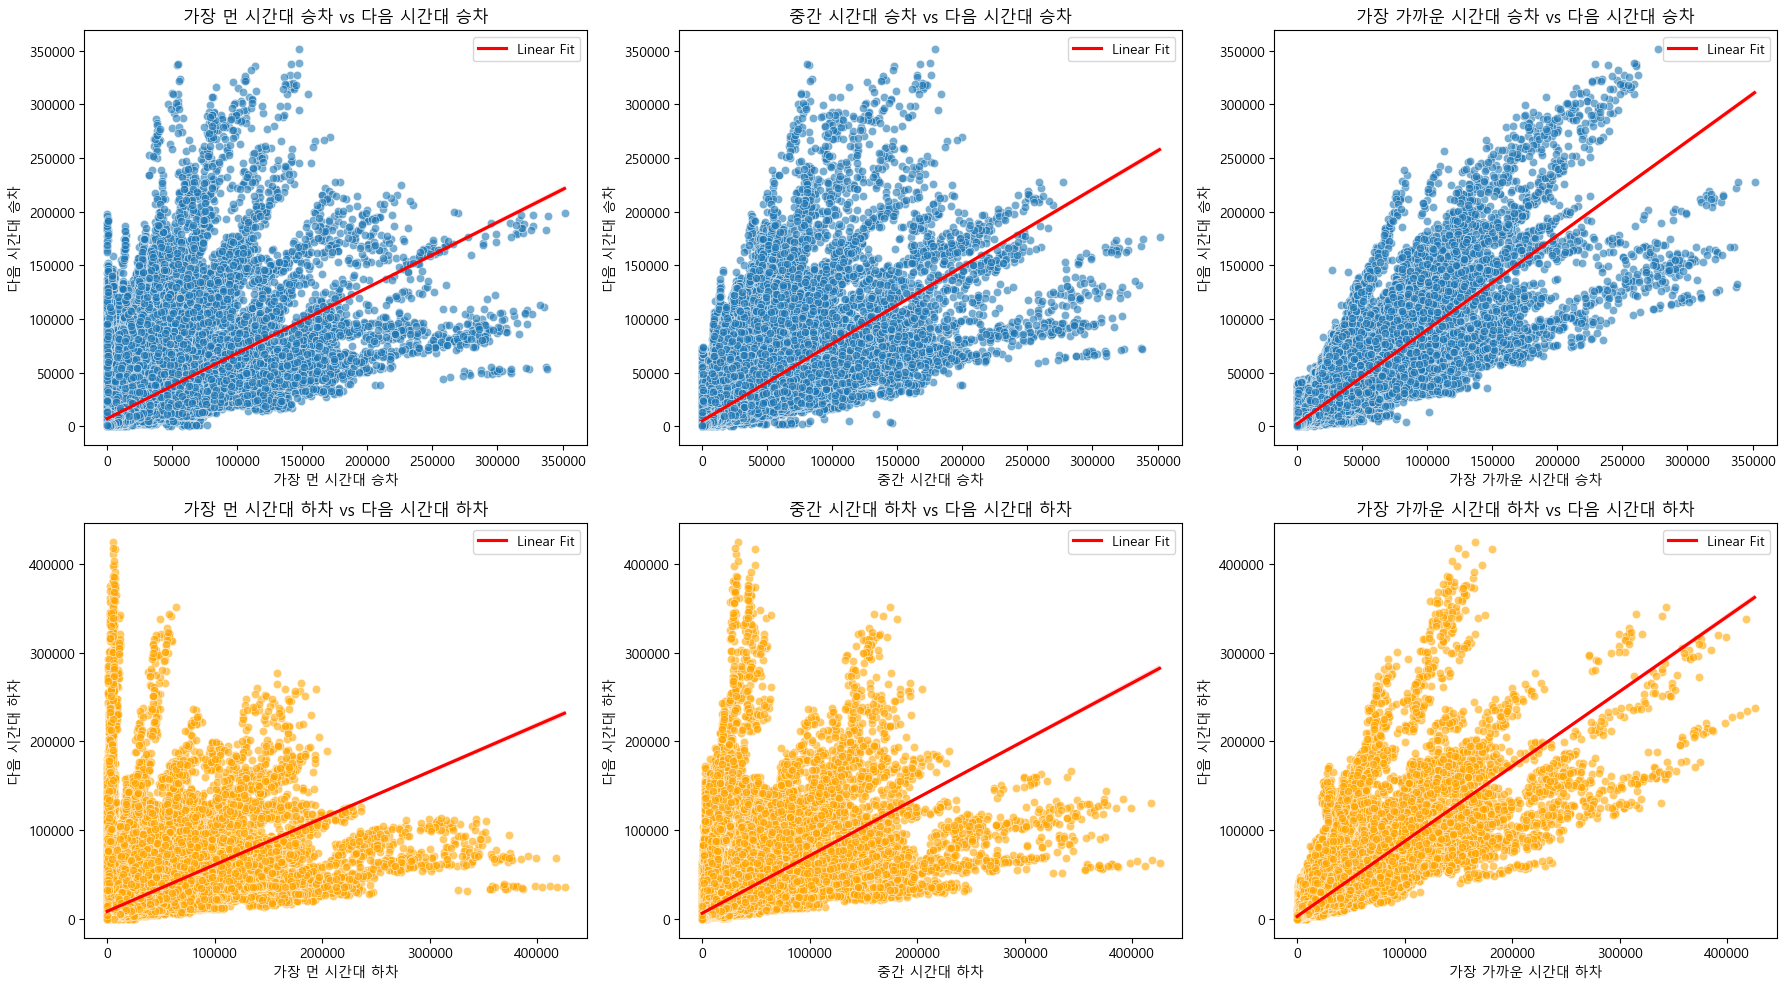

In [23]:
import seaborn as sns           # 고급 시각화를 위한 seaborn 임포트

labels_boarding = ['가장 먼 시간대 승차', '중간 시간대 승차', '가장 가까운 시간대 승차']
# 승차 변수별 라벨 정의

labels_alighting = ['가장 먼 시간대 하차', '중간 시간대 하차', '가장 가까운 시간대 하차']
# 하차 변수별 라벨 정의

X_boarding_vars = [far_boarding, mid_boarding, close_boarding]
# 시간대별 승차 변수 리스트

X_alighting_vars = [far_alighting, mid_alighting, close_alighting]
# 시간대별 하차 변수 리스트

plt.figure(figsize=(18, 10))  # 전체 플롯 크기 설정

# 승차 산점도 및 회귀선
for i, (x, label) in enumerate(zip(X_boarding_vars, labels_boarding), 1):
    plt.subplot(2, 3, i)  # 2행 3열 중 i번째 위치에 서브플롯 생성
    sns.scatterplot(x=x.flatten(), y=next_boarding_arr.flatten(), alpha=0.6)
    # x: 해당 시간대의 승차 인원, y: 다음 시간대 승차 인원, 투명도 0.6
    sns.regplot(x=x.flatten(), y=next_boarding_arr.flatten(), scatter=False, color='red', label='Linear Fit')
    # 산점도 위에 선형 회귀선(적색)만 추가, 산점도는 따로 표시하지 않음
    plt.xlabel(label)
    plt.ylabel('다음 시간대 승차')
    plt.title(f'{label} vs 다음 시간대 승차')
    plt.legend()

# 하차 산점도 및 회귀선
for i, (x, label) in enumerate(zip(X_alighting_vars, labels_alighting), 4):
    plt.subplot(2, 3, i)  # 2행 3열 중 i번째 위치에 서브플롯 생성
    sns.scatterplot(x=x.flatten(), y=next_alighting_arr.flatten(), alpha=0.6, color='orange')
    # x: 해당 시간대의 하차 인원, y: 다음 시간대 하차 인원, 주황색 산점도
    sns.regplot(x=x.flatten(), y=next_alighting_arr.flatten(), scatter=False, color='red', label='Linear Fit')
    # 회귀선(적색)만 추가
    plt.xlabel(label)
    plt.ylabel('다음 시간대 하차')
    plt.title(f'{label} vs 다음 시간대 하차')
    plt.legend()

plt.tight_layout()  # 서브플롯 간 간격 자동 조정
plt.show()          # 플롯 출력



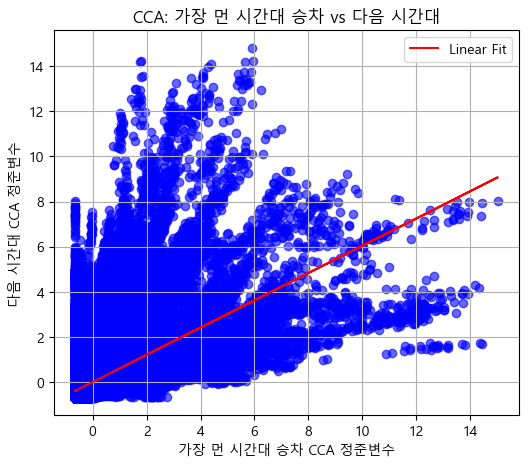

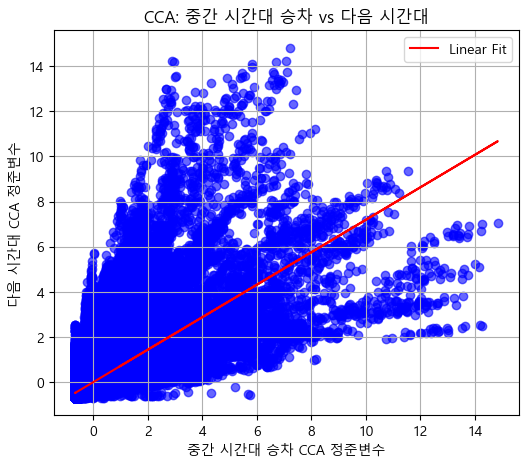

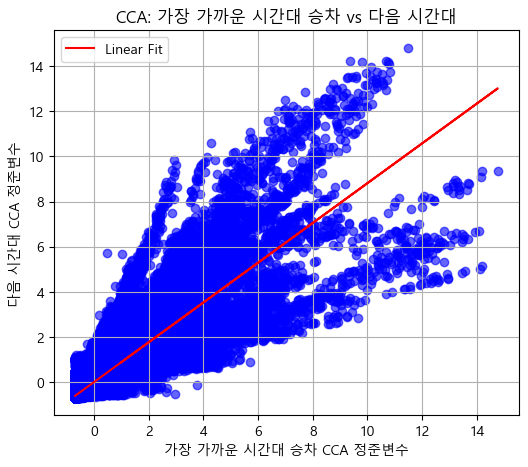

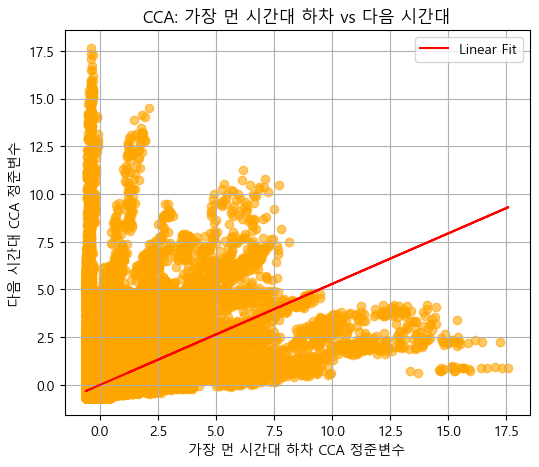

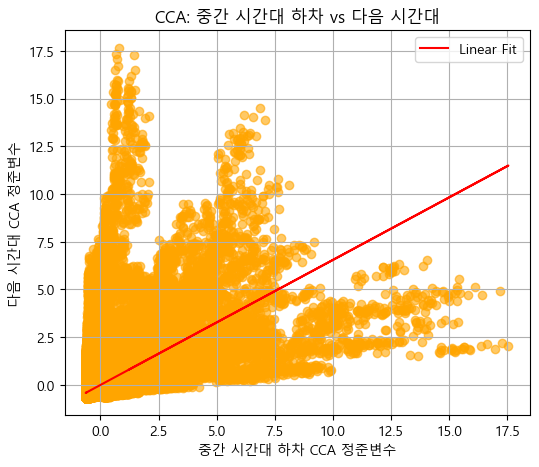

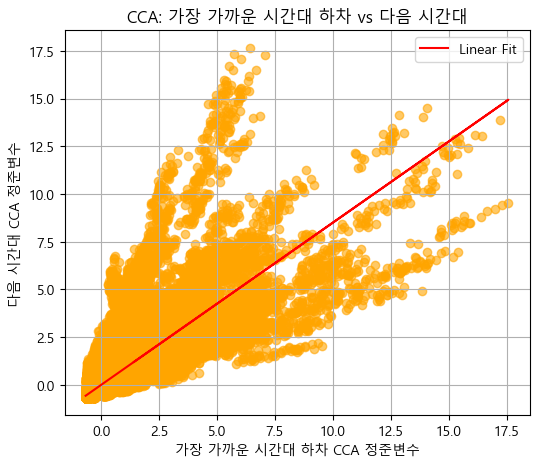

In [24]:
for x, label, next_arr, color in zip(
    X_boarding_vars + X_alighting_vars,  # 승차/하차 입력 변수 6개(3+3)
    labels_boarding + labels_alighting,  # 각 변수에 대한 한글 라벨 6개
    [next_boarding_arr]*3 + [next_alighting_arr]*3,  # 승차/하차 예측 대상 배열
    ['blue']*3 + ['orange']*3  # 승차는 파란색, 하차는 주황색
):
    cca.fit(x, next_arr)
    # 각 입력 변수(x)와 다음 시간대 변수(next_arr)에 대해 CCA(정준상관분석) 모델 적합

    x_c, y_c = cca.transform(x, next_arr)
    # x, next_arr를 정준변수(CCA canonical variate)로 변환

    plt.figure(figsize=(6, 5))
    plt.scatter(x_c, y_c, alpha=0.6, color=color)
    # 정준변수 공간에서 산점도 시각화 (투명도 0.6)

    coef = np.polyfit(x_c.flatten(), y_c.flatten(), 1)
    poly1d_fn = np.poly1d(coef)
    # 1차(선형) 다항식 회귀계수 계산 및 함수 생성

    plt.plot(x_c, poly1d_fn(x_c), color='red', label='Linear Fit')
    # 산점도 위에 선형 회귀선(적색) 추가

    plt.xlabel(f'{label} CCA 정준변수')
    plt.ylabel('다음 시간대 CCA 정준변수')
    plt.title(f'CCA: {label} vs 다음 시간대')
    plt.legend()
    plt.grid(True)
    plt.show()
    # 각 변수별로 CCA 정준변수 공간에서의 관계를 개별 플롯으로 시각화



In [25]:
from scipy.stats import pearsonr, spearmanr
from tableone import TableOne

# 시간대별 승차/하차 컬럼 추출 및 정렬
승차_cols = sorted([col for col in data.columns if '승차' in col])
# '승차'가 포함된 컬럼명만 추출 후 시간 순서대로 정렬

하차_cols = sorted([col for col in data.columns if '하차' in col])
# '하차'가 포함된 컬럼명만 추출 후 시간 순서대로 정렬

# 연속된 3개 시간대의 승차/하차(6개)와 그 다음 시간대 승차/하차(2개) 추출
X_list, Y_list = [], []
for idx, row in data.iterrows():
    for i in range(len(승차_cols) - 3):
        x = []
        for j in range(3):
            x.append(row[승차_cols[i + j]])    # j번째 시간대 승차 인원
            x.append(row[하차_cols[i + j]])    # j번째 시간대 하차 인원
        y = [row[승차_cols[i + 3]], row[하차_cols[i + 3]]]  # 다음 시간대 승차/하차
        X_list.append(x)
        Y_list.append(y)
X = np.array(X_list)  # 입력 특성 배열 (N, 6)
Y = np.array(Y_list)  # 타깃 배열 (N, 2)

# 가장 먼, 중간, 제일 가까운 시간대별 승차/하차 분리
far_time = X[:, 0:2]    # 가장 먼 시간대(첫 번째) 승차, 하차
mid_time = X[:, 2:4]    # 중간 시간대(두 번째) 승차, 하차
close_time = X[:, 4:6]  # 제일 가까운 시간대(세 번째) 승차, 하차
next_time = Y           # 다음 시간대 승차, 하차

# TableOne 기술통계 요약
columns = ['far_승차', 'far_하차', 'mid_승차', 'mid_하차', 'close_승차', 'close_하차', '다음승차', '다음하차']
table_df = pd.DataFrame(
    np.hstack([far_time, mid_time, close_time, next_time]),
    columns=columns
)
# TableOne에 사용할 데이터프레임 생성 (각 시간대별 승차/하차 + 다음 시간대)

table1 = TableOne(table_df, columns=columns, nonnormal=columns)
# 모든 컬럼을 비정규분포로 간주하여 TableOne 기술통계 요약 생성
print(table1.tabulate(tablefmt="github"))
# TableOne 결과를 GitHub 스타일 표로 출력

# 상관계수 계산 함수
def calc_corr(x, y):
    pearson_corrs, pearson_ps = [], []
    spearman_corrs, spearman_ps = [], []
    for i in range(x.shape[1]):
        pc, pp = pearsonr(x[:, i], y[:, i])      # 피어슨 상관계수 및 p-value
        sc, sp = spearmanr(x[:, i], y[:, i])     # 스피어만 상관계수 및 p-value
        pearson_corrs.append(pc)
        pearson_ps.append(pp)
        spearman_corrs.append(sc)
        spearman_ps.append(sp)
    return pearson_corrs, pearson_ps, spearman_corrs, spearman_ps

# 각 시간대별로 승차/하차와 다음 시간대 승차/하차의 상관계수 계산
labels = ['가장 먼', '중간', '제일 가까운']
all_corrs = []
for arr, label in zip([far_time, mid_time, close_time], labels):
    pearson_corrs, pearson_ps, spearman_corrs, spearman_ps = calc_corr(arr, next_time)
    for i, direction in enumerate(['승차', '하차']):
        all_corrs.append({
            '시간대': label,
            '변수': direction,
            '피어슨 상관계수': pearson_corrs[i],
            '피어슨 p-value': pearson_ps[i],
            '스피어만 상관계수': spearman_corrs[i],
            '스피어만 p-value': spearman_ps[i]
        })

corr_df = pd.DataFrame(all_corrs)
print(corr_df)
# 각 시간대별 승차/하차와 다음 시간대 승차/하차 간의 상관 분석 결과를 표로 출력


|                            |    | Missing   | Overall                 |
|----------------------------|----|-----------|-------------------------|
| n                          |    |           | 312102                  |
| far_승차, median [Q1,Q3]   |    | 0         | 7777.0 [605.0,19154.0]  |
| far_하차, median [Q1,Q3]   |    | 0         | 6683.0 [743.0,18459.0]  |
| mid_승차, median [Q1,Q3]   |    | 0         | 8435.0 [1473.0,19829.0] |
| mid_하차, median [Q1,Q3]   |    | 0         | 7595.0 [933.0,19232.8]  |
| close_승차, median [Q1,Q3] |    | 0         | 8959.0 [2377.2,20308.8] |
| close_하차, median [Q1,Q3] |    | 0         | 8423.0 [1857.0,19834.0] |
| 다음승차, median [Q1,Q3]   |    | 0         | 9158.0 [2813.0,20435.0] |
| 다음하차, median [Q1,Q3]   |    | 0         | 8888.0 [2744.2,20041.0] |
      시간대  변수  피어슨 상관계수  피어슨 p-value  스피어만 상관계수  스피어만 p-value
0    가장 먼  승차  0.603789          0.0   0.668837           0.0
1    가장 먼  하차  0.529004          0.0   0.710447           0.0
2      중간  승차  0.719